# A Bayesian Billiard game

## Import of modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from scipy import special

# Not really needed, but nicer plots
import seaborn as sns
sns.set()
sns.set_context("talk")

## Illustrative example: A Bayesian billiard game
Adapted by Christian Forssen from the blog post [Frequentism and Bayesianism II: When Results Differ](http://jakevdp.github.io/blog/2014/06/06/frequentism-and-bayesianism-2-when-results-differ/) for the TALENT course on Bayesian methods in June, 2019, with some later tweaks by Dick Furnstahl. 

This example of nuisance parameters dates all the way back to the posthumous [1763 paper](http://www.stat.ucla.edu/history/essay.pdf) written by Thomas Bayes himself. The particular version of this problem used here is borrowed from [Eddy 2004](https://halfonlab.ccr.buffalo.edu/Bioinformatics%20Primers%20from%20Nature%20Biotechnology/Eddy_2004_Nat%20Biotechnol-15340486.pdf).

The setting is a rather contrived game in which Alice and Bob bet on the outcome of a process they can't directly observe:

Alice and Bob enter a room. Behind a curtain there is a billiard table, which they cannot see, but their friend Carol can. Carol rolls a ball down the table, and marks where it lands. This divides the table into two regions, to the left and to the right of the mark.  Once this mark is in place, Carol begins rolling new balls down the table with random starting directions. If the ball finishes in the left region, Alice gets a point; if it finishes in the right region, Bob gets a point.  We will assume for the sake of example that all of Carol's rolls are unbiased: that is, the balls have an equal chance of ending up anywhere on the table.  The first person to reach **six points** wins the game.

Here the location of the mark (determined by the first roll) can be considered a nuisance parameter: it is unknown, and not of immediate interest, but it clearly must be accounted for when predicting the outcome of subsequent rolls. If the first roll settles far to the right, then subsequent rolls will favor Alice. If it settles far to the left, Bob will be favored instead.

Given this setup, here is the question we ask of ourselves:

> In a particular game, after eight rolls, Alice has five points and Bob has three points. What is the probability that Bob will go on to win the game?

Intuitively, you probably realize that because Alice received five of the eight points, the marker placement likely favors her. And given this, it's more likely that the next roll will go her way as well. And she has three opportunities to get a favorable roll before Bob can win; she seems to have clinched it.  But, **quantitatively**, what is the probability that Bob will squeak-out a win? (We can imagine they are going to make a side bet on Bob winning; what odds should Bob ask for?)

### A Naive Frequentist Approach
Someone following a classical frequentist approach might reason as follows:

To determine the result, we need an intermediate estimate of where the marker sits. We'll quantify this marker placement as a probability $\alpha$ that any given roll lands in Alice's favor.  Because five balls out of eight fell on Alice's side of the marker, we can quickly show that the maximum likelihood estimate of $\alpha$ is given by:

$$
\hat{\alpha} = 5/8
$$

(This result follows in a straightforward manner from the [binomial likelihood](http://en.wikipedia.org/wiki/Binomial_distribution)). Assuming this maximum likelihood estimate, we can compute the probability that Bob will win, which is given by:

$$
p(B) = (1 - \hat{\alpha})^3
$$

That is, he needs to win three rolls in a row. Thus, we find that the following estimate of the probability:

In [2]:
alpha_hat = 5. / 8.
freq_prob = (1 - alpha_hat) ** 3
print(f"Naive frequentist probability of Bob winning: {freq_prob:.3f}")
print(f"or\nOdds against Bob winning: {(1. - freq_prob) / freq_prob:.0f} to 1")

Naive frequentist probability of Bob winning: 0.053
or
Odds against Bob winning: 18 to 1


So we've estimated using frequentist ideas that Alice will win about 17 times for each time Bob wins. Let's try a Bayesian approach next.

### Bayesian approach

We can also approach this problem from a Bayesian standpoint. This is slightly more involved, and requires us to first define some notation.

We'll consider the following random variables:

- $B$ = Bob Wins;
- $D$ = observed data, i.e. $D = (n_A, n_B) = (5, 3)$;
- $I$ = other information that we have, e.g. concerning the rules of the game;
- $\alpha$ = unknown position of the mark in the current game.

We want to compute $p(B~|~D,I)$; that is, the probability that Bob wins given our observation that Alice currently has five points to Bob's three.

In the following, we will not explicitly include $I$ in the expressions for conditional probabilities. However, it should be assumed to be part of the known propositions, e.g. 

$$p(B~|~D)\equiv p(B~|~D,I),$$

$$p(\alpha) \equiv p(\alpha~|~I),$$ 

etc. 


The general Bayesian method of treating nuisance parameters is *marginalization*, or integrating the joint probability over the entire range of the nuisance parameter. In this case, that means that we will first calculate the joint distribution

$$
p(B,\alpha~|~D)
$$

and then marginalize over $\alpha$ using the following identity:

$$
p(B~|~D) \equiv \int_{-\infty}^\infty p(B,\alpha~|~D)\, {\mathrm d}\alpha
$$

This identity follows from the definition of conditional probability, and the law of total probability: that is, it is a fundamental consequence of probability axioms and will always be true. Even a frequentist would recognize this; they would simply disagree with our interpretation of $p(\alpha|I)$ (appearing below) as being a measure of uncertainty of our own knowledge.

#### Building our Bayesian Expression

To compute this result, we will manipulate the above expression for $p(B~|~D)$ until we can express it in terms of other quantities that we can compute.

We'll start by applying the following definition of [conditional probability](http://en.wikipedia.org/wiki/Conditional_probability#Definition) to expand the term $p(B,\alpha~|~D)$:

$$
p(B~|~D) = \int P(B~|~\alpha, D) P(\alpha~|~D) \mathrm{d}\alpha
$$

Next we use [Bayes' rule](http://en.wikipedia.org/wiki/Bayes%27_theorem) to rewrite $p(\alpha~|~D)$:

$$
p(B~|~D) = \int p(B~|~\alpha, D) \frac{p(D~|~\alpha)p(\alpha)}{p(D)} \mathrm{d}\alpha
$$

Finally, using the same probability identity we started with, we can expand $p(D)$ in the denominator to find:

$$
p(B~|~D) = \frac{\int p(B~|~\alpha,D) p(D~|~\alpha) p(\alpha) \mathrm{d}\alpha}{\int p(D~|~\alpha)p(\alpha) \mathrm{d}\alpha}
$$

Now the desired probability is expressed in terms of three quantities that we can compute. Let's look at each of these in turn:

- $p(B~|~\alpha,D)$: This term is exactly the frequentist likelihood we used above. In words: given a marker placement $\alpha$ and the fact that Alice has won 5 times and Bob 3 times, what is the probability that Bob will go on to six wins?  Bob needs three wins in a row, i.e. $p(B~|~\alpha,D) = (1 - \alpha) ^ 3$.
- $p(D~|~\alpha)$: this is another easy-to-compute term. In words: given a probability $\alpha$, what is the likelihood of exactly 5 positive outcomes out of eight trials? The answer comes from the well-known [Binomial distribution](http://en.wikipedia.org/wiki/Binomial_distribution): in this case $p(D~|~\alpha) \propto \alpha^5 (1-\alpha)^3$
- $p(\alpha)$: this is our prior on the probability $\alpha$. By the problem definition, we can assume that $\alpha$ is evenly drawn between 0 and 1.  That is, $p(\alpha)$ is a uniform probability distribution in the range from 0 to 1.

Putting this all together, canceling some terms, and simplifying a bit, we find

$$
p(B~|~D) = \frac{\int_0^1 (1 - \alpha)^6 \alpha^5 \mathrm{d}\alpha}{\int_0^1 (1 - \alpha)^3 \alpha^5 \mathrm{d}\alpha}
$$

where both integrals are evaluated from 0 to 1.

These integrals are special cases of the [Beta Function](http://en.wikipedia.org/wiki/Beta_function):

$$
\beta(n, m) = \int_0^1 (1 - t)^{n - 1} t^{m - 1} dt
$$

The Beta function can be further expressed in terms of gamma functions (i.e. factorials), but for simplicity we'll compute them directly using Scipy's beta function implementation:

In [3]:
from scipy.special import beta
bayes_prob = beta(6 + 1, 5 + 1) / beta(3 + 1, 5 + 1)

print(f"p(B|D) = {bayes_prob:.3f}")
print(f'or\nBayesian odds against Bob winning: ',
      f' {(1. - bayes_prob) / bayes_prob:.0f} to 1')

p(B|D) = 0.091
or
Bayesian odds against Bob winning:   10 to 1


So we see that the Bayesian result gives us 10 to 1 odds, which is quite different than the 17 to 1 odds found using the frequentist approach. So which one is correct?

### Brute-force (Monte Carlo) approach

For this type of well-defined and simple setup, it is actually relatively easy to use a Monte Carlo simulation to determine the correct answer. This is essentially a brute-force tabulation of possible outcomes: we generate a large number of random games, and simply count the fraction of relevant games that Bob goes on to win. The current problem is especially simple because so many of the random variables involved are uniformly distributed.  We can use the ``numpy`` package to do this as follows:

In [4]:
# Setting the random seed here with an integer argument will generate the
#  same sequence of pseudo-random numbers.  We can use this to reproduce
#  previous sequences.  If call statement this statement without an argument,
#  np.random.seed(), then we will get a new sequence every time we rerun. 
np.random.seed()

# Set how many times we will play a random game (an integer).
num_games = 100000

# Play num_games games with randomly-drawn alphas, between 0 and 1
#  So alphas here is an array of 100000 values, which represent the true value 
#   of alpha in successive games.
alphas = np.random.random(num_games)

# Now generate an 11-by-num_games array of random numbers between 0 and 1.
#  These represent the 11 rolls in each of the num_games games.
#  We need at most 11 rolls for one player to reach 6 wins, but of course
#   the game would be over if one player reaches 6 wins earlier.
# [Note: np.shape(rolls) will tell you the dimensions of the rolls array.] 
rolls = np.random.random((11, len(alphas)))

# count the cumulative wins for Alice and Bob at each roll
Alice_count = np.cumsum(rolls < alphas, 0)
Bob_count = np.cumsum(rolls >= alphas, 0)

# sanity check: total number of wins should equal number of rolls
total_wins = Alice_count + Bob_count
assert np.all(total_wins.T == np.arange(1, 12))
print("(Sanity check passed)")

(Sanity check passed)


In [5]:
# Determine the number of games that meet our criterion of 
#  (A wins, B wins) = (5, 3), which means Bob's win count at eight rolls must 
#  equal exactly 3.  Index 7 of Bob_count must therefore be 3.
# The expression: Bob_count[7,:] == 3   will be either True or False for each
#  of the num_games entries.  The sequence of True and False values will be 
#  stored in the good_games array. (Try looking at the good_games array.)
good_games = Bob_count[7,:] == 3
# If we apply .sum() to good_games, it will add 1 for True and 0 for False,
#  so good_games.sum() is the total number of Trues.
print(f'Number of suitable games: {good_games.sum():d} ',
      f'(out of {len(alphas):d} simulated ones)')

# Truncate our results to consider only the suitable games.  We use the
#  good_games array as a template to select out the True games and redefine
#  Alice_count and Bob_count.  
Alice_count = Alice_count[:, good_games]
Bob_count = Bob_count[:, good_games]

# Determine which of these games Bob won.
#  To win, he must reach six wins after 11 rolls. So we look at the last
#  value for all of the suitable games: Bob_count[10,:] and count how
#  many equal 6.
bob_won = np.sum(Bob_count[10,:] == 6)
print(f'Number of these games Bob won: {bob_won:d}')

# Compute the probability
mc_prob = bob_won / good_games.sum()
print(f'Monte Carlo Probability of Bob winning: {mc_prob:.3f}')
print(f'MC Odds against Bob winning: {(1. - mc_prob) / mc_prob:.0f} to 1')

Number of suitable games: 11061  (out of 100000 simulated ones)
Number of these games Bob won: 1023
Monte Carlo Probability of Bob winning: 0.092
MC Odds against Bob winning: 10 to 1


The Monte Carlo approach gives 10-to-1 odds on Bob, which agrees with the Bayesian result. Apparently, our naive frequentist approach above was flawed.

### Discussion

This example shows different approaches to dealing with the presence of a nuisance parameter $\alpha$. The Monte Carlo simulation gives us a close brute-force estimate of the true probability (assuming the validity of our assumptions), which the Bayesian approach matches. The naive frequentist approach, by utilizing a single maximum likelihood estimate of the nuisance parameter $\alpha$, arrives at the wrong result.

We should emphasize that **this does not imply frequentism itself is incorrect**. The incorrect result above is more a matter of the approach being "naive" than it being "frequentist". There certainly exist frequentist methods for handling this sort of nuisance parameter – for example, it is theoretically possible to apply a transformation and conditioning of the data to isolate the dependence on $\alpha$ – but it's hard to find any approach to this particular problem that does not somehow take advantage of Bayesian-like marginalization over $\alpha$.

Another potential point of contention is that the question itself is posed in a way that is perhaps unfair to the classical, frequentist approach. A frequentist might instead hope to give the answer in terms of null tests or confidence intervals: that is, they might devise a procedure to construct limits which would provably bound the correct answer in $100\times(1 - \alpha)$ percent of similar trials, for some value of $\alpha$, say 0.05. This might be classically accurate, but it doesn't quite answer the question at hand. 

In contrast, Bayesianism provides a better approach for this sort of problem: by simple algebraic manipulation of a few well-known axioms of probability within a Bayesian framework, we can straightforwardly arrive at the correct answer without need for other special expertise.

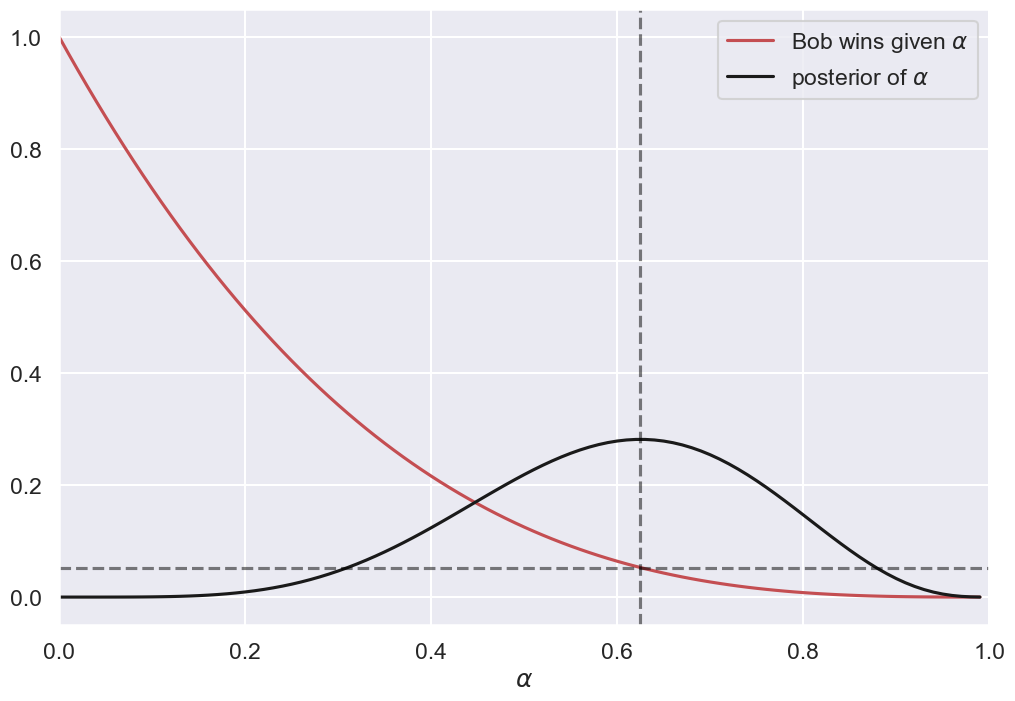

In [6]:
from math import comb
alphas = np.arange(0,1,.01)
alphahat = 5/8

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.plot(alphas, (1-alphas)**3, '-r', label=r'Bob wins given $\alpha$')
ax.plot(alphas, comb(8, 5) * alphas**5 * (1-alphas)**3, '-k', label=r'posterior of $\alpha$')
#ax.plot(alphas, comb(8, 5) * alphas**5 * (1-alphas)**6, '-b', label=r'product')
ax.axvline(alphahat, color='black', ls='--', alpha=0.5)
ax.axhline((1-alphahat)**3, color='black', ls='--', alpha=0.5)
ax.set_xlabel(r'$\alpha$')
ax.set_xlim(0, 1)
ax.legend();